In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp viz

# viz

> Vizualization routines

Pretty much an exact dupe of https://github.com/zqevans/audio-diffusion/blob/main/viz/viz.py

In [ ]:
#|export 
import math
from pathlib import Path
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
import numpy as np
from PIL import Image

import torch
from torch import optim, nn
from torch.nn import functional as F
import torchaudio
import torchaudio.transforms as T
import librosa 
from einops import rearrange

import wandb
import numpy as np
import pandas as pd

In [ ]:
#export
def embeddings_table(tokens):
    "make a table of embeddings for use with wandb"
    features, labels = [], []
    embeddings = rearrange(tokens, 'b d n -> b n d') # each demo sample is n vectors in d-dim space
    for i in range(embeddings.size()[0]):  # nested for's are slow but sure ;-) 
        for j in range(embeddings.size()[1]):
            features.append(embeddings[i,j].detach().cpu().numpy())
            labels.append([f'demo{i}'])    # labels does the grouping / color for each point
    features = np.array(features)
    #print("\nfeatures.shape = ",features.shape)
    labels = np.concatenate(labels, axis=0)
    cols = [f"dim_{i}" for i in range(features.shape[1])]
    df   = pd.DataFrame(features, columns=cols)
    df['LABEL'] = labels
    return wandb.Table(columns=df.columns.to_list(), data=df.values)

In [ ]:
#export
def proj_pca(tokens, proj_dims=3):
    "this projects via PCA, grabbing the first _3_ dimensions"
    A = rearrange(tokens, 'b d n -> (b n) d') # put all the vectors into the same d-dim space
    if A.shape[-1] > proj_dims: 
        k = proj_dims
        (U, S, V) = torch.pca_lowrank(A)
        proj_data = torch.matmul(A, V[:, :k])  # this is the actual PCA projection step
    else:
        proj_data = A
    return torch.reshape(proj_data, (tokens.size()[0], -1, proj_dims)) # put it in shape [batch, n, 3]

In [ ]:
#export
def pca_point_cloud(tokens, color_scheme='batch'):
    "produces a 3D wandb point cloud of the tokens using PCA. tokens has shape (b, d, n)"
    data = proj_pca(tokens).cpu().numpy()
    points = []
    if color_scheme=='batch':
        cmap, norm = cm.tab20, Normalize(vmin=0, vmax=data.shape[0])
    else: 
        cmap, norm = cm.viridis, Normalize(vmin=0, vmax=data.shape[1])
    print("   pca_point_cloud: data.shape = ",data.shape)
    for bi in range(data.shape[0]):  # batch index
        if color_scheme=='batch': [r, g, b, _] = [int(255*x) for x in cmap(norm(bi))] 
        for n in range(data.shape[1]):
            if color_scheme!='batch': [r, g, b, _] = [int(255*x) for x in cmap(norm(n))] 
            #print(f"  {data[bi,n,0]}, {data[bi,n,1]}, {data[bi,n,2]}, {r}, {g}, {b}")
            points.append([data[bi,n,0], data[bi,n,1], data[bi,n,2], r, g, b])

    point_cloud = np.array(points)
    print("   pca_point_cloud: point_cloud.shape = ",point_cloud.shape)
    return wandb.Object3D(point_cloud)

In [ ]:
#|export
def print_stats(waveform, sample_rate=None, src=None, print=print):
    "print stats about waveform. Taken verbatim from pytorch docs."
    if src:
        print(f"-" * 10)
        print(f"Source: {src}")
        print(f"-" * 10)
    if sample_rate:
        print(f"Sample Rate: {sample_rate}")
    print(f"Shape: {tuple(waveform.shape)}")
    print(f"Dtype: {waveform.dtype}")
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print('')
    print(f"{waveform}")
    print('')

In [ ]:
#|export
def spectrogram_image(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None, db_range=[-60,20], justimage=False):
    "Modified from PyTorch tutorial https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html"
    fig = Figure(figsize=(5, 4), dpi=100) if not justimage else Figure(figsize=(4.145, 4.145), dpi=100, tight_layout=True)
    canvas = FigureCanvasAgg(fig)
    axs = fig.add_subplot()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect, vmin=db_range[0], vmax=db_range[1])
    if xmax:
        axs.set_xlim((0, xmax))
    if justimage:
        axs.axis('off')
        plt.tight_layout()
    else: 
        axs.set_ylabel(ylabel)
        axs.set_xlabel('frame')
        axs.set_title(title or 'Spectrogram (dB)')
        fig.colorbar(im, ax=axs)
    canvas.draw()
    rgba = np.asarray(canvas.buffer_rgba())
    im = Image.fromarray(rgba)
    if justimage: # remove tiny white border
        b = 15 # border size 
        im = im.crop((b,b, im.size[0]-b, im.size[1]-b))
        #print(f"im.size = {im.size}")
    return im

In [ ]:
#export
def audio_spectrogram_image(waveform, power=2.0, sample_rate=48000, print=print, db_range=[-60,20], justimage=False, log=False):
    "Modified from PyTorch tutorial https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html"
    n_fft = 1024
    win_length = None
    hop_length = n_fft//2 # 512
    n_mels = 128

    mel_spectrogram_op = T.MelSpectrogram(
        sample_rate=sample_rate, n_fft=n_fft, win_length=win_length, 
        hop_length=hop_length, center=True, pad_mode="reflect", power=power, 
        norm='slaney', onesided=True, n_mels=n_mels, mel_scale="htk")

    melspec = mel_spectrogram_op(waveform.float())
    if log:
        print_stats(melspec, print=print)
        print(f"torch.max(melspec) = {torch.max(melspec)}")
        print(f"melspec.shape = {melspec.shape}")
    melspec = melspec[0] # TODO: only left channel for now
    return spectrogram_image(melspec, title="MelSpectrogram", ylabel='mel bins (log freq)', db_range=db_range, justimage=justimage)

Let's test the above routine

Resampling examples/example.wav from 44100 Hz to 48000 Hz


/home/shawley/envs/aeiou/lib/python3.10/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


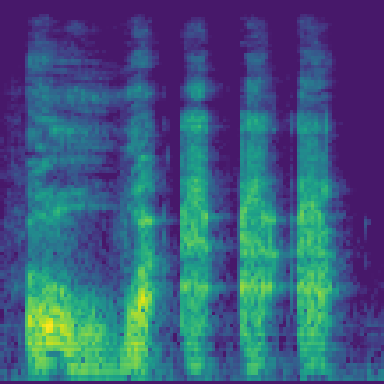

<Figure size 432x288 with 0 Axes>

In [ ]:
#|slow
if True:
    from aeiou.core import load_audio
    from IPython.display import display # to display images

    audio_filename = 'examples/example.wav'
    waveform = load_audio(audio_filename)
    spec_graph = audio_spectrogram_image(waveform, justimage=True)
    display(spec_graph)

In [ ]:
#|export
def tokens_spectrogram_image(tokens, aspect='auto', title='Embeddings', ylabel='index'):
    embeddings = rearrange(tokens, 'b d n -> (b n) d') 
    print(f"tokens_spectrogram_image: embeddings.shape = ",embeddings.shape)
    fig = Figure(figsize=(10, 4), dpi=100)
    canvas = FigureCanvasAgg(fig)
    axs = fig.add_subplot()
    axs.set_title(title or 'Embeddings')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('time frame')
    im = axs.imshow(embeddings.cpu().numpy().T, origin='lower', aspect=aspect, interpolation='none') #.T because numpy is x/y 'backwards'
    fig.colorbar(im, ax=axs)
    canvas.draw()
    rgba = np.asarray(canvas.buffer_rgba())
    return Image.fromarray(rgba)

In [ ]:
#|export
def plot_jukebox_embeddings(zs, aspect='auto'):
    fig, ax = plt.subplots(nrows=len(zs))
    for i, z in enumerate(zs):
        #z = torch.squeeze(z)
        z = z.cpu().numpy()
        x = np.arange(z.shape[-1])
        im = ax[i].imshow(z, origin='lower', aspect=aspect, interpolation='none')

    #plt.legend()
    plt.ylabel("emb (top=fine, bottom=coarse)")
    return {"chart": plt}

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()